# S4 Flow Modelling

**Structural uncertainty due to fault timing: a multi-model case study from the Perth Basin**<br><br>Bardot, K., Lesueur, M., Siade, A. J., Lang, S. C. and McCallum, J. L. (2024)

routines run


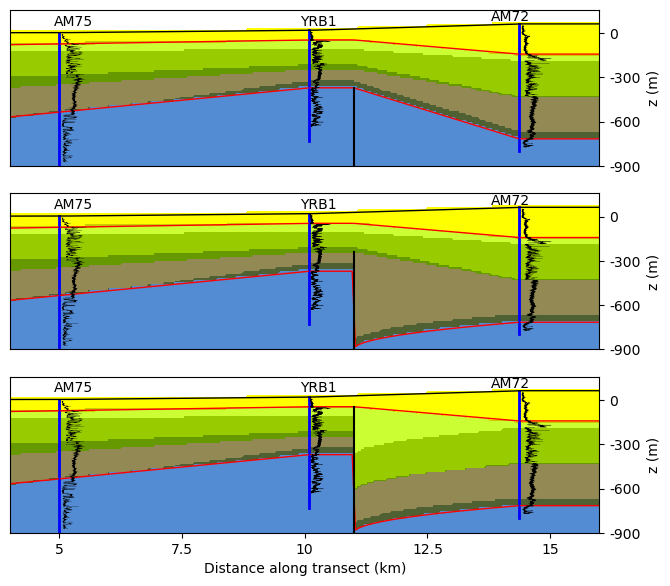

In [1]:
%run ./S3_geology.ipynb

### STEADY-STATE

In [2]:
sim_name = 'sim' 
workspace = '../modelfiles/'
exe_name = '../exe/mf6.exe'
model_names = ['S1','S2','S3']

gwf_all, h_ss = [], []

for model in range(3): # THREE STRUCTURAL MODELS
        modelname = model_names[model]
        sim = flopy.mf6.MFSimulation(sim_name=sim_name, version='mf6',exe_name=exe_name,sim_ws=workspace)
        tdis = flopy.mf6.modflow.mftdis.ModflowTdis(sim, time_units='DAYS', nper=1,perioddata=[1., 1, 1.])
        ims = flopy.mf6.ModflowIms(sim, print_option='ALL', complexity='complex',outer_dvclose=1.e-3, inner_dvclose=1.e-5, outer_maximum=200)
        gwfname = "gwf_" + modelname
        gwf = flopy.mf6.ModflowGwf(sim, modelname=gwfname, save_flows=True) 
        dis = flopy.mf6.modflow.mfgwfdis.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol, 
                                                            delr=delr,delc=delc,top=A.top, botm=A.bot, idomain = A.idomain) 
        npf = flopy.mf6.modflow.mfgwfnpf.ModflowGwfnpf(gwf, xt3doptions=xt3d,k=hk_all[model], k22=hk_all[model], k33=vk_all[model], 
                                                       angle1 = 0., angle2 = angle2_all[model], angle3 = 0.,
                                                      )
        sto = flopy.mf6.modflow.mfgwfsto.ModflowGwfsto(gwf, storagecoefficient=None, iconvert=0, ss=ss_all[model])
        ic = flopy.mf6.ModflowGwfic(gwf, strt = strt)      
        ch = flopy.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, maxbound=len(A.chd),stress_period_data=A.chd)
        rch = flopy.mf6.modflow.mfgwfrch.ModflowGwfrch(gwf, maxbound=len(A.rch),stress_period_data=A.rch)        
        oc = flopy.mf6.ModflowGwfoc(gwf,head_filerecord='{}.hds'.format(modelname), saverecord=[('HEAD', 'ALL')], printrecord=None)

        sim.write_simulation()
        success, buff = sim.run_simulation(silent = True)
        print(success)
        
        hds = gwf.output.head()
        head = hds.get_alldata()
        h_ss.append(head) 
        gwf_all.append(gwf)


writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model gwf_S1...
    writing model name file...
    writing package dis...
    writing package npf...
    writing package sto...
    writing package ic...
    writing package chd_0...
    writing package rch_0...
    writing package oc...
True
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model gwf_S2...
    writing model name file...
    writing package dis...
    writing package npf...
    writing package sto...
    writing package ic...
    writing package chd_0...
    writing package rch_0...
    writing package oc...
True
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model gwf_S3...
    writing model name file...
    writing package dis...
    writing package npf...
    writ

0
1
2


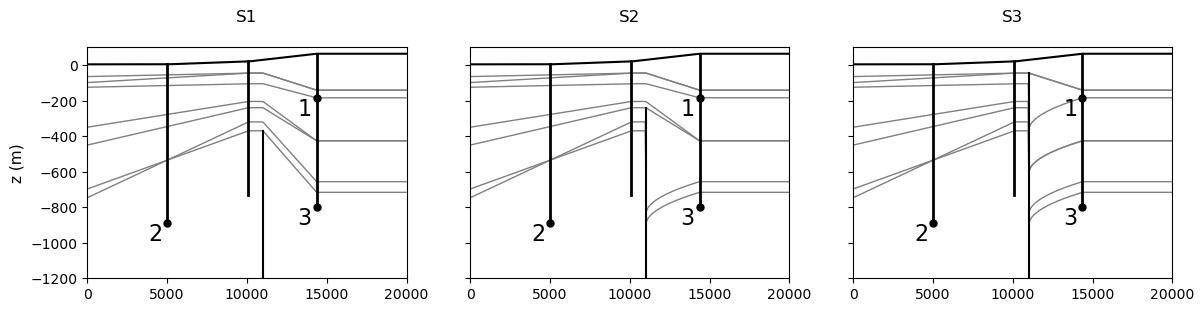

In [4]:
figure = True
if figure == True:

    fig = plt.figure(figsize=(14,3))
    vmin, vmax = -10, 10
    cmap = 'coolwarm'
    hstep, kstep = int(ncol/25), int(nlay/25)
    levels = [-10, -5, 0, 5, 10]
    for model in range(3):  
        print(model)
        array = h_ss[model][0][:,0,:]
        ax = plt.subplot(1,3,model+1,aspect='auto')
        ax.plot(xc, groundlevel, color = 'black')

        for n in range(nlith): 
            plt.plot(xi,bot_strat_all[model][n], lw = 1.0, c= 'grey')
        xsect = flopy.plot.PlotCrossSection(model=gwf_all[model], line={'Row': 0}, extent = extent)
        ax.annotate("AM75",(AM75.x,AM75.ground+100), size = 10)#, bbox=dict(facecolor = 'white'))
        ax.annotate("YRB1",(YMB1.x,AM75.ground+100), size = 10)#, bbox=dict(facecolor = 'white'))
        ax.annotate("AM72",(AM72.x,AM75.ground+100), size = 10)#, bbox=dict(facecolor = 'white'))
        ax.plot([AM75.x, AM75.x],[AM75.ground, AM75.jy], color = 'black', lw = 2.)
        ax.plot([YMB1.x, YMB1.x],[YMB1.ground, YMB1.jy], color = 'black', lw = 2.)
        ax.plot([AM72.x, AM72.x],[AM72.ground, AM72.jy], color = 'black', lw = 2.)
        ax.plot([fault_x, fault_x],[-1200, fault_top_all[model]], color='black')
        ax.set_ylim([-1200, zmax])
        if model > 0: ax.set(yticklabels=[])
        if model == 0: ax.set_ylabel('z (m)', size = 11)
        ax.set_title(model_names[model] + '\n', size = 12)
        for j in range(2,5):
            ax.plot(obs_coords[j][0], obs_coords[j][1], 'o', ms = 5, color = 'black')
            ax.annotate(j-1,(obs_coords[j][0]-1200,obs_coords[j][1]-100), size = 16)


In [5]:
# TDIS
years, ts_per_year = 40, 18 #20, 18
perlen = [1, 365 * years] #30,365* years
nper = len(perlen)
nstp = [1, years*ts_per_year] 
tsmult = [1.0, 1.0]
tdis_rc = []
for i in range(nper): 
    tdis_rc.append((perlen[i], nstp[i], tsmult[i])) 

# WEL
wel_col, wel_row = x_to_col(YMB1.x, delr), 0
wel_top = z_to_lay(-371, delz, zmax)
wel_bot = z_to_lay(-725, delz, zmax)
nwell_cells = wel_bot - wel_top

wel_loc = [(z_to_lay(-300, delz, zmax), 0, x_to_col(YMB1.x, delr)), 
           (z_to_lay(-1000, delz, zmax), 0, x_to_col(YMB1.x, delr))]

spd0, spd1 = [], []
for lay in range(wel_top, wel_bot):
    spd0.append([(lay, wel_row, wel_col), 0., 0.])
    spd1.append([(lay, wel_row, wel_col), qwell/nwell_cells, cwell])

spd_wel = {0: spd0, 1: spd1}

### TRANSIENT FLOW MODEL

In [6]:
gwf_all, h_results, c_results, h_alltime, c_alltime = [], [], [], [], []

model_names = ['S1','S2','S3']
for model in range(3): # THREE STRUCTURAL MODELS
        modelname = model_names[model]
        print(modelname)         

        sim = flopy.mf6.MFSimulation(sim_name=sim_name, version='mf6',exe_name=exe_name,sim_ws=workspace)
        tdis = flopy.mf6.modflow.mftdis.ModflowTdis(sim, time_units='DAYS', nper=nper,perioddata=tdis_rc)
        ims = flopy.mf6.ModflowIms(sim, print_option='ALL', complexity='complex',outer_dvclose=1.e-3, inner_dvclose=1.e-5, outer_maximum=200)
        
        gwfname = "gwf_" + modelname
        gwf = flopy.mf6.ModflowGwf(sim, modelname=gwfname, save_flows=True) 
        dis = flopy.mf6.modflow.mfgwfdis.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol, 
                                                            delr=delr,delc=delc,top=A.top, botm=A.bot, idomain = A.idomain) 
        npf = flopy.mf6.modflow.mfgwfnpf.ModflowGwfnpf(gwf, xt3doptions=xt3d,k=hk_all[model], k22=hk_all[model], k33=vk_all[model], 
                                                       angle1 = 0., angle2 = angle2_all[model], angle3 = 0.)
        sto = flopy.mf6.modflow.mfgwfsto.ModflowGwfsto(gwf, storagecoefficient=None, iconvert=0, ss=ss_all[model])
        wel = flopy.mf6.modflow.mfgwfwel.ModflowGwfwel(gwf, print_input=True, print_flows=True, stress_period_data = spd_wel, 
                                                           save_flows=False, auxiliary="CONCENTRATION", pname="WEL-1", filename="{}.wel".format(gwfname))   
        ic = flopy.mf6.ModflowGwfic(gwf, strt = h_ss[model][0])      
        ch = flopy.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, maxbound=len(A.chd),stress_period_data=A.chd)
        rch = flopy.mf6.modflow.mfgwfrch.ModflowGwfrch(gwf, maxbound=len(A.rch),stress_period_data=A.rch)
        pname = 'head_obs_' + str(model) 
        print(pname)
        obs = flopy.mf6.ModflowUtlobs(gwf, pname=pname, filename="{}.obs".format(gwfname),
                                              print_input=True, continuous=obs_gwf_recarray[model])
        
        oc = flopy.mf6.ModflowGwfoc(gwf,head_filerecord='{}.hds'.format(modelname), 
                                    saverecord=[('HEAD','FREQUENCY',9)], 
                                    printrecord=None)
        
        gwtname = "gwt_" + modelname # MF6 groundwater transport package
        gwt = flopy.mf6.MFModel(sim,model_type="gwt6", modelname=gwtname, model_nam_file="{}.nam".format(gwtname))
        gwt.name_file.save_flows = True
        imsgwt = flopy.mf6.ModflowIms(sim,print_option="ALL",outer_dvclose=hclose,outer_maximum=nouter,under_relaxation="NONE",
                    inner_maximum=ninner, inner_dvclose=hclose, rcloserecord=rclose, linear_acceleration="BICGSTAB",
                    scaling_method="NONE", reordering_method="NONE",relaxation_factor=relax,
                    filename="{}.ims".format(gwtname))
        sim.register_ims_package(imsgwt, [gwt.name])

        flopy.mf6.ModflowGwtdis(gwt,nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,top=A.top,botm=A.bot,idomain=A.idomain) #DIS
        flopy.mf6.ModflowGwtic(gwt, strt=sconc, filename="{}.ic".format(gwtname)) # IC
        flopy.mf6.ModflowGwtadv(gwt, scheme=scheme, filename="{}.adv".format(gwtname)) # ADV
        flopy.mf6.ModflowGwtdsp(gwt,xt3d_off=True,alh=al,ath1=ath1,filename="{}.dsp".format(gwtname)) # DSP

        # Instantiating MODFLOW 6 transport mass storage package (formerly "reaction" package in MT3DMS)
        flopy.mf6.ModflowGwtmst(gwt,porosity=prsity,first_order_decay=False,decay=None,decay_sorbed=None,
                    sorption=None,bulk_density=None,distcoef=None,filename="{}.mst".format(gwtname))

        sourcerecarray = [("WEL-1", "AUX", "CONCENTRATION")]
        flopy.mf6.ModflowGwtssm(gwt, sources=sourcerecarray) # SOURCE-SINK MIXING
        pname = 'conc_obs_' + str(model) 
        flopy.mf6.ModflowUtlobs(gwt, pname=pname, filename="{}.obs".format(gwtname),
                                              print_input=True, continuous=obs_gwt_recarray[model])
        flopy.mf6.ModflowGwtoc(gwt,concentration_filerecord="{}.ucn".format(gwtname),
                    concentrationprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
                    saverecord=[("CONCENTRATION", "FREQUENCY",9)], printrecord=None)

        flopy.mf6.ModflowGwfgwt(sim,exgtype="GWF6-GWT6",exgmnamea=gwfname,exgmnameb=gwtname)
        
        sim.write_simulation()
        success, buff = sim.run_simulation(silent = True)
        print(success)
        
        hds = gwf.output.head()
        times = hds.get_times()
        head = hds.get_data(totim=times[-1])
        head_time = hds.get_alldata()
        
        ucn = gwt.output.concentration() # GET CONC OUTPUT
        times = ucn.get_times()
        conc = ucn.get_data(totim=times[-1])
        conc_time = ucn.get_alldata()

        h_results.append(head) # last time step
        h_alltime.append(head_time)
        c_results.append(conc) # last time step
        c_alltime.append(conc_time)
        gwf_all.append(gwf)


S1
head_obs_0
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing ims package ims_0...
  writing package sim.gwfgwt...
  writing model gwf_S1...
    writing model name file...
    writing package dis...
    writing package npf...
    writing package sto...
    writing package wel-1...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 25 based on size of stress_period_data
    writing package ic...
    writing package chd_0...
    writing package rch_0...
    writing package head_obs_0...
    writing package oc...
  writing model gwt_S1...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package adv...
    writing package dsp...
    writing package mst...
    writing package ssm...
    writing package conc_obs_0...
    writing package oc...
True
S2
head_obs_1
writing simulation...
  writing simulation name file...
  writing simulation tdis pac

In [7]:
c_alltime = np.asarray(c_alltime)
c_for_obs = np.moveaxis(c_alltime, 1,-1)

h_alltime = np.array(h_alltime)
h_for_obs = np.moveaxis(h_alltime, 1,-1)

time_years = []
for t in times:
    time_years.append(t/365)
    
drawdown_all = []
for model in range(3): 
    initial = h_ss[model][0][:,0,:]
    initial[initial == 1e30] = 0.
    end = h_alltime[model][-1][:,0,:]
    end[end == 1e30] = 0.
    drawdown_all.append(end - initial)

### Save results

In [8]:
pickle.dump(times, open('../results/times.pkl', 'wb'))
pickle.dump(c_alltime, open('../results/c_results_mean.pkl', 'wb')) # Save results to file for processing
pickle.dump(h_alltime, open('../results/h_results_mean.pkl', 'wb'))
pickle.dump(drawdown_all, open('../results/dd_results_mean.pkl', 'wb'))
pickle.dump(gwf_all, open('../results/gwf_all.pkl', 'wb'))

### Plot for 3 models

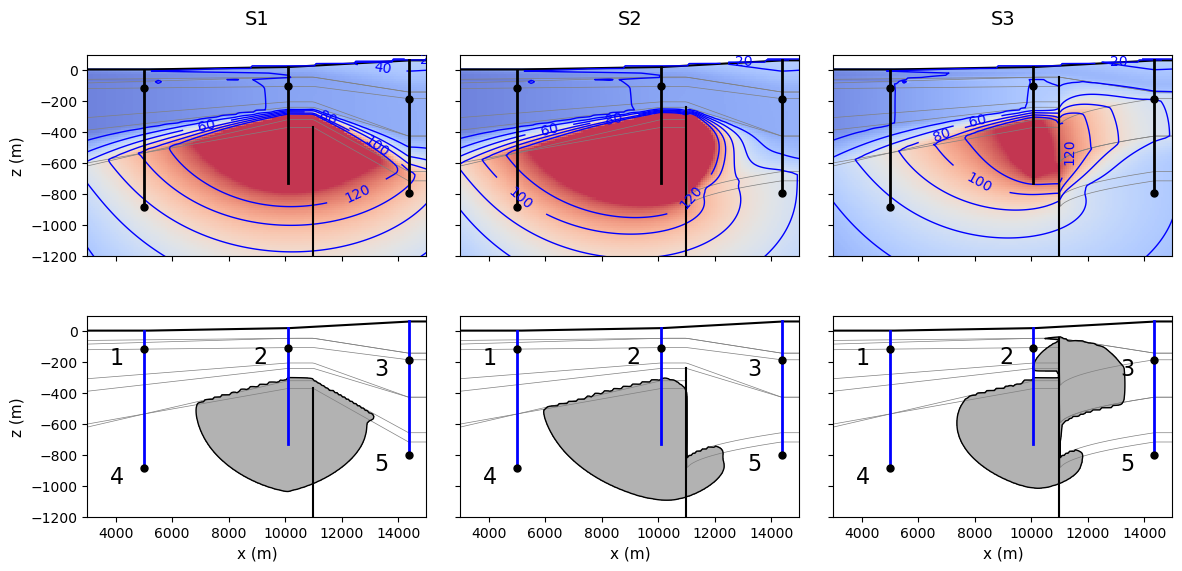

In [9]:
fig = plt.figure(figsize=(14,6))

# HEAD
vmin, vmax = 0, 140 
cmap = 'coolwarm'
hstep, kstep = int(ncol/25), int(nlay/25)
levels = [20, 40, 60, 80, 100, 120] # Injection
for model in range(3):  
    drawdown = drawdown_all[model]
    ax = plt.subplot(2,3,model+1,aspect='auto')
    ax.plot(xc, groundlevel, color = 'black')
    for n in range(nlith): 
        plt.plot(xi,bot_strat_all[model][n], lw = 0.5, c= 'grey')
    xsect = flopy.plot.PlotCrossSection(model=gwf_all[model], line={'Row': 0}, extent = extent)
    csa = xsect.plot_array(drawdown, masked_values=[0], cmap = cmap, alpha=0.8, vmin = vmin, vmax = vmax) 
     
    CS = ax.contour(X, Z, drawdown, levels,colors='Blue', linewidths=1., linestyles = 'solid')
    ax.clabel(CS, inline=1, fontsize=10, fmt='%1.0f')

    ax.annotate("AM75",(AM75.x,AM75.ground+100), size = 10)#, bbox=dict(facecolor = 'white'))
    ax.annotate("YRB1",(YMB1.x,AM75.ground+100), size = 10)#, bbox=dict(facecolor = 'white'))
    ax.annotate("AM72",(AM72.x,AM75.ground+100), size = 10)#, bbox=dict(facecolor = 'white'))
    ax.plot([AM75.x, AM75.x],[AM75.ground, AM75.jy], color = 'black', lw = 2.)
    ax.plot([YMB1.x, YMB1.x],[YMB1.ground, YMB1.jy], color = 'black', lw = 2.)
    ax.plot([AM72.x, AM72.x],[AM72.ground, AM72.jy], color = 'black', lw = 2.)
    ax.plot([fault_x, fault_x],[zmin, fault_top_all[model]], color='black')
    ax.set_title(model_names[model] + '\n', size = 12)
    ax.set_ylim([-1200, zmax])
    ax.set_xlim([3000, 15000])
    if model > 0: ax.set(yticklabels=[])
    if model == 0: ax.set_ylabel('z (m)', size = 11)
    ax.set(xticklabels=[])
    ax.set_title(model_names[model] + '\n', size = 14)
    for j in range(5):
        ax.plot(obs_coords[j][0], obs_coords[j][1], 'o', ms = 5, color = 'black')
        
# CONC

for model in range(3): 
    ax = plt.subplot(2,3,model+4,aspect='auto')
    ax.plot(xc, groundlevel, color = 'black')
    for n in range(nlith): 
        plt.plot(xi,bot_strat_all[model][n], lw = 0.5, c= 'grey')
    xsect = flopy.plot.PlotCrossSection(model=gwf_all[model], line={'Row': 0}, extent = extent)
    array = c_results[model][:,0,:]
    array[array == 1e30] = 0.
    levels = [0.5] 
    CS = ax.contour(X, Z, array, levels,colors='Black', linewidths=1.0, linestyles = 'solid')
    levels = [0.5, 110] 
    ax.contourf(X, Z, array, levels, cmap='binary', alpha = 0.6)
    ax.plot([AM75.x, AM75.x],[AM75.ground, AM75.jy], color = 'blue', lw = 2.)
    ax.plot([YMB1.x, YMB1.x],[YMB1.ground, YMB1.jy], color = 'blue', lw = 2.)
    ax.plot([AM72.x, AM72.x],[AM72.ground, AM72.jy], color = 'blue', lw = 2.)
    ax.plot([fault_x, fault_x],[zmin, fault_top_all[model]], color='black')

    ax.set_ylim([-1200, zmax])
    ax.set_xlim([3000, 15000])
    ax.set_xlabel('x (m)', size = 11)
    if model > 0: ax.set(yticklabels=[])
    if model == 0: ax.set_ylabel('z (m)', size = 11)
    
    for j in range(5):
        ax.plot(obs_coords[j][0], obs_coords[j][1], 'o', ms = 5, color = 'black')
        ax.annotate(j+1,(obs_coords[j][0]-1200,obs_coords[j][1]-100), size = 16)

plt.subplots_adjust(wspace=0.1, hspace=0.3)
plt.show()

###  Create parameter sets

In [10]:
# LAYER K
nr_param = 200 # Create lots of parameter sets
nr = 100 # How many successful flow models we want
import random 
logfunc = lambda e: np.log10(e)

def normal_sampling(mu, sigma, nr_param):
    nums = [] 
    count = 0
    while count < nr_param:
        temp = random.gauss(mu,sigma) 
        if temp >= mu - 3 * sigma and temp <= mu + 3*sigma:
            nums.append(temp)
            count += 1
    return(nums)

hk_mu = np.copy(hk) # from variables.ipynb
hk_mu_log = logfunc(hk_mu)
hk_sigma_log = [0.66, 0.66, 0.66, 0.66, 0.66, 0.66, 0.66, 0.66]

vk_mu = np.copy(vk) # from variables.ipynb
vk_mu_log = logfunc(vk_mu)
vk_sigma_log = [0.66, 0.66, 0.66, 0.66, 0.66, 0.66, 0.66, 0.66]

hk_parameters = []
vk_parameters = []

for n in range(8): # for each layer
    hk_parameters.append(normal_sampling(hk_mu_log[n], hk_sigma_log[n], nr_param))

C:\Users\19904604\AppData\Local\Temp\ipykernel_16968\1503520241.py:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,2,1,aspect='auto')
C:\Users\19904604\AppData\Local\Temp\ipykernel_16968\1503520241.py:23: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,2,2,aspect='auto')


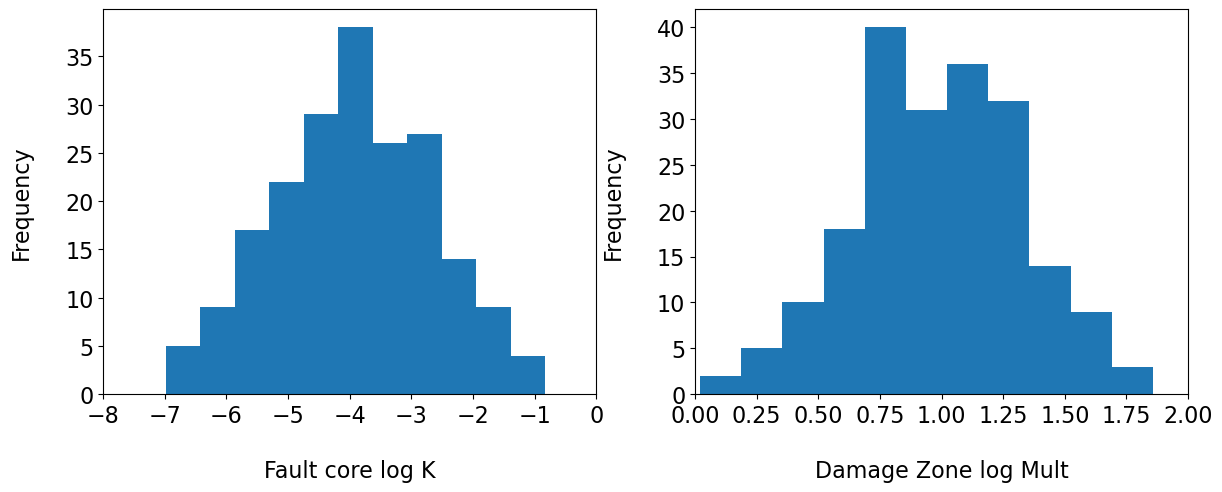

In [11]:
# FAULT ZONE (BARRIER/CONDUIT)
core_mu = -4 # MEAN LOG K
core_sigma = 4/3 # 4 OOM eiter side of mean, 3 std dev
core_parameters_log = normal_sampling(core_mu, core_sigma, nr_param)
core_parameters = [10**n for n in core_parameters_log]

dzm_mu = 1 # MEAN LOG Scale (i.e. log 10)
dzm_sigma = 0.33 # 1 OOM eiter side of mean, 3 std dev
dzm_parameters_log = normal_sampling(dzm_mu, dzm_sigma, nr_param)
dzm_parameters = [10**n for n in dzm_parameters_log]

fig, axes = plt.subplots(1,2, figsize=(14,5),sharex=True, sharey=True)
ax = plt.subplot(1,2,1,aspect='auto')
#ax.set_title('core parameters')
ax.set_xlabel('\nFault core log K', size = 16)
ax.set_ylabel('Frequency\n', size = 16)
ax.set_xlim([-8, 0])
#ax.set_xticks(ticks = [-8, -6, -4, -2, 0],size = 16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.hist(core_parameters_log, bins = 11)   

ax = plt.subplot(1,2,2,aspect='auto')
#ax.set_title('dz multiplier parameters')
ax.set_xlabel('\nDamage Zone log Mult', size = 16)
ax.set_ylabel('Frequency\n', size = 16)
ax.set_xlim([0, 2])
#ax.set_xticks(ticks = [0, 0.5, 1, 1.5, 2],size = 16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.hist(dzm_parameters_log, bins = 11)

plt.savefig('histograms_fault.tif', dpi=450)

#### Plot parameter sets

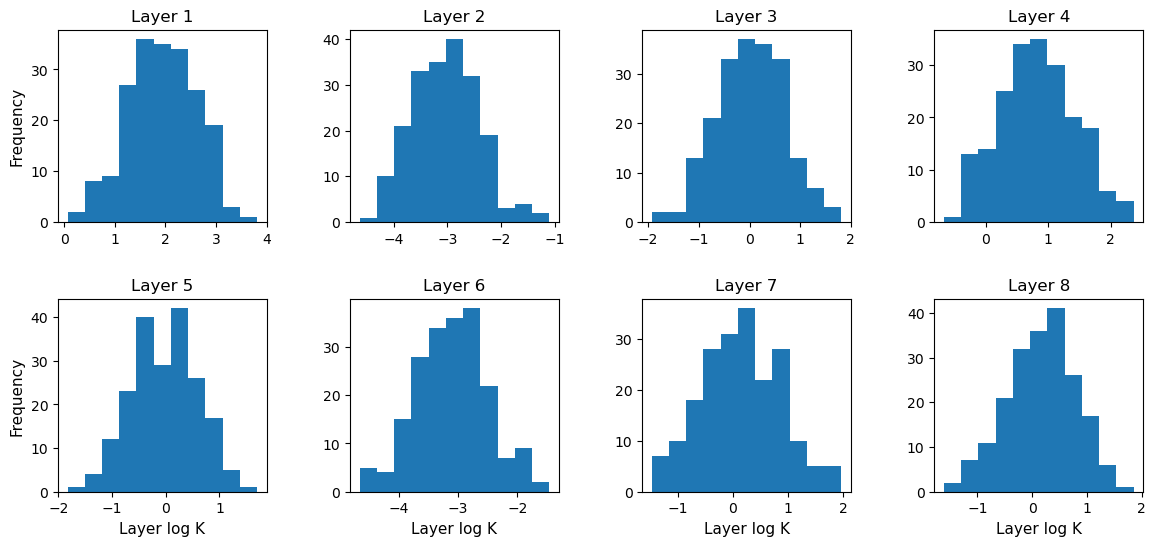

<Figure size 640x480 with 0 Axes>

In [12]:
fig = plt.figure(figsize=(14,6))
for i in range(8):
    ax = plt.subplot(2,4,i+1,aspect='auto')
    ax.set_title('Layer %i' %(i+1))
    if i > 3: ax.set_xlabel('Layer log K', size = 11)
    if i == 0 or i == 4: ax.set_ylabel('Frequency', size = 11)
    ax.hist(hk_parameters[:][i], bins = 11) 
    #ax.set_xticks(ticks = [hk_mu_log[i]-1, hk_mu_log[i]-0.5, hk_mu_log[i], hk_mu_log[i]+0.5, hk_mu_log[i]+1],
    #              labels = [hk_mu_log[i]-1, hk_mu_log[i]-0.5, hk_mu_log[i], hk_mu_log[i]+0.5, hk_mu_log[i]+1],
    #              size = 16) 
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

plt.savefig('histograms_layers.tif', dpi=450)

In [21]:
def set_k_arrays(layer_test, conduit_test, barrier_test):
    
    hk_model_run, vk_model_run, hfb_model_run = [], [], []

    for model in range(3): # THREE STRUCTURAL MODELS
        hk_model, vk_model, hfb_model = [], [], []
                
        for n in range(nr_param):  
            hk_run = np.copy(hk_all[model]) # starts by assuming mean hk vk
            vk_run = np.copy(vk_all[model])
            layers_array = layers_all[model]
            
            if layer_test == True:
                #print('layer_test')
                hk = 10**hk_parameters[:][n]
                hk_run = np.copy(layers_array)
                #hk_run[hk_run == -1] = 999999 # above ground
                for lith in range(nlith): # HK / VK/ SS
                    hk_run[hk_run == lith] = hk[lith]
                vk_run = hk_run / 100
                
            if conduit_test == True:
                #print('conduit_test')
                
                for k in range(nlay):
                    if zc[k] < fault_top_all[model]: 
                        for col in range(fault_leftcol-1, fault_rightcol+2): # 2 x col left of fault, 2 x col right
                            #print(model, n, k, col)
                            #print(len(hk_run))
                            hk_run[k, 0, col] = hk_run[k, 0, col] * dzm_parameters[n]
                            #print(hk_run[k, 0, col] * dzm_parameters[n])
                            vk_run[k, 0, col] = vk_run[k, 0, col] * dzm_parameters[n]
            
            if barrier_test == True:
                #print('barrier_test')
                hfb_run = [] 
                for k in range(nlay):
                    if zc[k] < fault_top_all[model]: 
                        hfb_run.append(([k, 0, fault_leftcol], [k,0,fault_rightcol], core_parameters[n]))
            else:
                hfb_run = []
                for k in range(nlay):
                    if zc[k] < fault_top_all[model]: 
                        hfb_run.append(([k, 0, fault_leftcol], [k,0,fault_rightcol], 100.)) # Equivalent to no barrier
                
            hk_model.append(hk_run) 
            vk_model.append(vk_run) 
            hfb_model.append(hfb_run)
        hk_model_run.append(hk_model)
        vk_model_run.append(vk_model)
        hfb_model_run.append(hfb_model)
    return(hk_model_run, vk_model_run, hfb_model_run)



### Here is where to set if modifying layer K, conduit, barrier

In [22]:
hk_parameters = np.transpose(hk_parameters, [1,0]) # put sims before layers
vk_parameters = hk_parameters/100

layer_test = True
conduit_test = False
barrier_test = False
hk_model_run, vk_model_run, hfb_model_run = set_k_arrays(layer_test, conduit_test, barrier_test) 

if layer_test == True and conduit_test == False: scenario = 'lay'
if conduit_test == True and layer_test == False: scenario = 'con'
if barrier_test == True and conduit_test == False: scenario = 'bar'
if barrier_test == True and conduit_test == True: scenario = 'all'
print(scenario)

lay


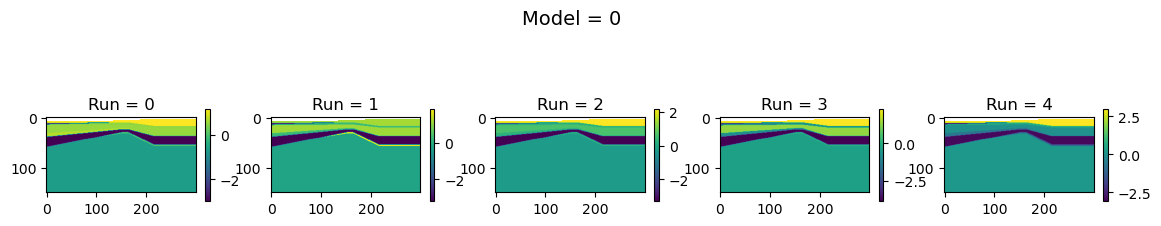

In [23]:
model = 0
nr_plot = 5
fig = plt.figure(figsize=(14,3))
fig.suptitle("Model = %i" %model, size = 14)
for n in range(5): # Plot first 5 runs 
    ax = plt.subplot(1,nr_plot,n+1,aspect='auto')
    ax.set_title('Run = %i' %n)
    array = logfunc(hk_model_run[model][n]) # the last run
    plt.imshow(array[:,0,:])#, vmin = 0, vmax = 60)   
    plt.colorbar(shrink = 0.4)
plt.show()


In [24]:
worked = np.zeros((3,nr_param))


In [25]:
h_results, c_results, dd_results, obs_results = [], [], [], []

for model in range(3): # Just doing for 1st
    
    modelname = model_names[model]
    c_model, h_model, dd_model, obs_model = [], [], [], []
    n = 0
    n_param = 0
    while n < nr:
        simname = "sim_" + modelname
        gwfname = "gwf_" + modelname
    
        sim = flopy.mf6.MFSimulation(sim_name=simname, version='mf6',exe_name=exe_name,sim_ws=workspace)
        tdis = flopy.mf6.modflow.mftdis.ModflowTdis(sim, time_units='DAYS', nper=nper,perioddata=tdis_rc)
        ims = flopy.mf6.ModflowIms(sim, print_option='ALL', complexity='complex',outer_dvclose=1.e-3, inner_dvclose=1.e-5, outer_maximum=200)

        print(modelname, n)
            
        hk_array = hk_model_run[model][n_param]
        vk_array = vk_model_run[model][n_param]
        
        gwf = flopy.mf6.ModflowGwf(sim, modelname=gwfname, save_flows=True) #newtonoptions="NEWTON UNDER_RELAXATION",
        dis = flopy.mf6.modflow.mfgwfdis.ModflowGwfdis(gwf, nlay=A.nlay, nrow=A.nrow, ncol= A.ncol, 
                                                           delr=delr,delc=delc,top=A.top, botm=A.bot, idomain = A.idomain) 
        npf = flopy.mf6.modflow.mfgwfnpf.ModflowGwfnpf(gwf, xt3doptions=xt3d,k=hk_array, k22=hk_array, k33=vk_array, 
                                                           angle1 = 0., angle2 = angle2_all[model], angle3 = 0.)
        hfb = flopy.mf6.modflow.mfgwfhfb.ModflowGwfhfb(gwf, stress_period_data=hfb_model_run[model][n_param])
        sto = flopy.mf6.modflow.mfgwfsto.ModflowGwfsto(gwf, storagecoefficient=None, iconvert=0, ss=ss_array)
        wel = flopy.mf6.modflow.mfgwfwel.ModflowGwfwel(gwf, print_input=True, print_flows=True, stress_period_data = spd_wel, 
                                                       save_flows=False, auxiliary="CONCENTRATION", pname="WEL-1", filename="{}.wel".format(gwfname))   
        ic = flopy.mf6.ModflowGwfic(gwf, strt = h_ss[model])      
        ch = flopy.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, maxbound=len(A.chd),stress_period_data=A.chd, save_flows=True)
        rch = flopy.mf6.modflow.mfgwfrch.ModflowGwfrch(gwf, maxbound=len(A.rch),stress_period_data=A.rch)
        oc = flopy.mf6.ModflowGwfoc(gwf,head_filerecord='{}.hds'.format(modelname),
                                        saverecord=[('HEAD','FREQUENCY',9)], printrecord=None)
        gwtname = "gwt_" + modelname
        gwt = flopy.mf6.MFModel(sim,model_type="gwt6", modelname=gwtname, model_nam_file="{}.nam".format(gwtname))
        gwt.name_file.save_flows = True
        imsgwt = flopy.mf6.ModflowIms(sim,print_option="ALL",outer_dvclose=hclose,outer_maximum=nouter,under_relaxation="NONE",
                    inner_maximum=ninner, inner_dvclose=hclose, rcloserecord=rclose, linear_acceleration="BICGSTAB",
                    scaling_method="NONE", reordering_method="NONE",relaxation_factor=relax,
                    filename="{}.ims".format(gwtname))
        sim.register_ims_package(imsgwt, [gwt.name])

        flopy.mf6.ModflowGwtdis(gwt,nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,top=A.top,botm=A.bot,idomain=A.idomain) #DIS
        flopy.mf6.ModflowGwtic(gwt, strt=sconc, filename="{}.ic".format(gwtname)) # IC
        flopy.mf6.ModflowGwtadv(gwt, scheme=scheme, filename="{}.adv".format(gwtname)) # ADV
        flopy.mf6.ModflowGwtdsp(gwt,xt3d_off=True,alh=al,ath1=ath1,filename="{}.dsp".format(gwtname)) # DSP
        flopy.mf6.ModflowGwtmst(gwt,porosity=prsity,first_order_decay=False,decay=None,decay_sorbed=None,
                    sorption=None,bulk_density=None,distcoef=None,filename="{}.mst".format(gwtname))
        sourcerecarray = [("WEL-1", "AUX", "CONCENTRATION")]
        flopy.mf6.ModflowGwtssm(gwt, sources=sourcerecarray) # SOURCE-SINK MIXING
        flopy.mf6.ModflowGwtoc(gwt,concentration_filerecord="{}.ucn".format(gwtname),
                    concentrationprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
                    saverecord=[("CONCENTRATION", "FREQUENCY",9)],
                    printrecord=None)#[("CONCENTRATION", "LAST"), ("BUDGET", "LAST")])
        flopy.mf6.ModflowGwfgwt(sim,exgtype="GWF6-GWT6",exgmnamea=gwfname,exgmnameb=gwtname)
        sim.write_simulation(silent = True)
        success, buff = sim.run_simulation(silent = True)
        print(success)
        
        n_param += 1
        if success:
            worked[model][n_param] = 1
            n += 1 

            ml = sim.get_model(gwfname)
            hds = ml.output.head()
            head = hds.get_alldata()

            ucnobj = gwt.output.concentration() 
            times = ucnobj.get_times()
            conc = ucnobj.get_data(totim=times[-1])
            conc[conc == 1e30] = 0.

            initial = h_ss[model][0]
            initial[initial == 1e30] = 0.
            end = head[-1]
            end[end == 1e30] = 0.
            dd = end - initial

            c_model.append(conc) 
            h_model.append(head[-1])
            dd_model.append(dd)           

            h_alltime = np.array(head) # get in better format for obs
            #print('h_alltime.shape = ', h_alltime.shape)
            h_for_obs = np.moveaxis(h_alltime, 0,-1) # get in better format for obs
            #print('h_for_obs = ', h_for_obs.shape)

            obs_run = []
            for ob in range(5):
                obs_run.append(h_for_obs[obs_cells[ob]])
            obs_model.append(obs_run)
            
            print('End Model %i, Used parameters %i' %(n, n_param))

    c_results.append(c_model)
    h_results.append(h_model)
    dd_results.append(dd_model)
    obs_results.append(obs_model)
        
if layer_test == True and conduit_test == False: scenario = 'lay'
if conduit_test == True and layer_test == False: scenario = 'con'
if barrier_test == True and conduit_test == False: scenario = 'bar'
if barrier_test == True and conduit_test == True: scenario = 'all'
print(scenario)

pickle.dump(c_results, open('c_results_' + scenario + '.pkl', 'wb')) # Save results to file for processing
pickle.dump(h_results, open('h_results_' + scenario + '.pkl', 'wb'))
pickle.dump(dd_results, open('dd_results_' + scenario + '.pkl', 'wb'))
pickle.dump(obs_results, open('obs_results_' + scenario + '.pkl', 'wb'))


S1 0
True
End Model 1, Used parameters 1
S1 1
True
End Model 2, Used parameters 2
S1 2
True
End Model 3, Used parameters 3
S1 3
True
End Model 4, Used parameters 4
S1 4
True
End Model 5, Used parameters 5
S1 5
True
End Model 6, Used parameters 6
S1 6
True
End Model 7, Used parameters 7
S1 7
True
End Model 8, Used parameters 8
S1 8
True
End Model 9, Used parameters 9
S1 9
True
End Model 10, Used parameters 10
S1 10
True
End Model 11, Used parameters 11
S1 11
True
End Model 12, Used parameters 12
S1 12
True
End Model 13, Used parameters 13
S1 13
True
End Model 14, Used parameters 14
S1 14
True
End Model 15, Used parameters 15
S1 15
True
End Model 16, Used parameters 16
S1 16
True
End Model 17, Used parameters 17
S1 17
True
End Model 18, Used parameters 18
S1 18
True
End Model 19, Used parameters 19
S1 19
True
End Model 20, Used parameters 20
S1 20
True
End Model 21, Used parameters 21
S1 21
True
End Model 22, Used parameters 22
S1 22
True
End Model 23, Used parameters 23
S1 23
True
End M

True
End Model 89, Used parameters 89
S2 89
True
End Model 90, Used parameters 90
S2 90
True
End Model 91, Used parameters 91
S2 91
True
End Model 92, Used parameters 92
S2 92
True
End Model 93, Used parameters 93
S2 93
True
End Model 94, Used parameters 94
S2 94
True
End Model 95, Used parameters 95
S2 95
True
End Model 96, Used parameters 96
S2 96
True
End Model 97, Used parameters 97
S2 97
True
End Model 98, Used parameters 98
S2 98
True
End Model 99, Used parameters 99
S2 99
True
End Model 100, Used parameters 100
S3 0
True
End Model 1, Used parameters 1
S3 1
True
End Model 2, Used parameters 2
S3 2
True
End Model 3, Used parameters 3
S3 3
True
End Model 4, Used parameters 4
S3 4
True
End Model 5, Used parameters 5
S3 5
True
End Model 6, Used parameters 6
S3 6
True
End Model 7, Used parameters 7
S3 7
True
End Model 8, Used parameters 8
S3 8
True
End Model 9, Used parameters 9
S3 9
True
End Model 10, Used parameters 10
S3 10
True
End Model 11, Used parameters 11
S3 11
True
End Model